# Notebook objective
- Extract descriptive data about all radar files

In [2]:
import urllib.request
import tarfile
import wradlib as wrl
import h5py
import numpy as np
import glob
import datetime
import re
import pandas as pd
import matplotlib.pyplot as plt

# Helper functions


In [3]:
def extract_datetime(name):
    if 'NORPOL240_MIDNESHE' in name:
        date_start = len('NORPOL240_MIDNESHE_00_5_')
        substring_date = name[date_start:date_start+8]
        year = int(substring_date[:4])
        month = int(substring_date[4:6])
        day = int(substring_date[6:])
        
        time_start = len('NORPOL240_MIDNESHE_00_5_20150101_')
        substring_time = name[time_start:time_start + 4]
        hour = int(substring_time[:2])
        minute = int(substring_time[2:])
        
        timestamp = datetime.datetime(year,month,day,hour,minute)
        
    if 'T_PAGX40_C_BIRK' in name:
        date_start = len('T_PAGX40_C_BIRK_')
        substring_date = name[date_start:date_start+8]
        year = int(substring_date[:4])
        month = int(substring_date[4:6])
        day = int(substring_date[6:])
        
        time_start = len('T_PAGX40_C_BIRK_20150324')
        substring_time = name[time_start:time_start+4]
        hour = int(substring_time[:2])
        minute = int(substring_time[2:])
        
        timestamp = datetime.datetime(year,month,day,hour,minute)
        
    if 'dBZ.vol.hdf5' in name:
        date_start = 0
        substring_date = name[date_start:date_start+8]
        year = int(substring_date[:4])
        month = int(substring_date[4:6])
        day = int(substring_date[6:])
        
        time_start = len('20180101')
        substring_time = name[time_start:time_start+6]
        hour = int(substring_time[:2])
        minute = int(substring_time[2:4])
        second = int(substring_time[4:6])
        
        timestamp = datetime.datetime(year,month,day,hour,minute,second)
    return timestamp
print(extract_datetime('NORPOL240_MIDNESHE_00_5_20150101_0000_O.H5'))
print(extract_datetime('NORPOL240_MIDNESHE_00_5_20150101_0015_O.H5'))

print(extract_datetime('T_PAGX40_C_BIRK_20150324220000.h5'))
print(extract_datetime('T_PAGX40_C_BIRK_20150325110000.h5'))

print(extract_datetime('2018010100100000dBZ.vol.hdf5'))
print(extract_datetime('20180101002500dBZ.vol.hdf5'))

2015-01-01 00:00:00
2015-01-01 00:15:00
2015-03-24 22:00:00
2015-03-25 11:00:00
2018-01-01 00:10:00
2018-01-01 00:25:00


In [4]:
DIR_data = 'C:/Users/sverrirhd/vedurgogn/'
DIR_radar = DIR_data + '/radar/'
month_urls = glob.glob(DIR_radar + '*')
all_files = []
for m_url in month_urls:
    file_names = glob.glob(m_url + '/*')
    all_files.append(file_names)
all_files = np.concatenate(all_files)

In [5]:
file_endings = [(i.split('.')[1:]) for i in all_files]

In [6]:
unique_files = np.unique(file_endings)

C:\Users\sverrirhd\Anaconda3\envs\gis_wradlib_torch\lib\site-packages\numpy\lib\arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [7]:
file_endings = ['.H5','.h5','.tar.gz','.vol.hdf5']

In [8]:
# All file names
df_all_files = pd.DataFrame(all_files,columns = ['url'])

# Extract their ending
endings = {}
for ending in file_endings:
    endings[ending] = df_all_files.loc[:,'url'].str.contains(ending)
extension_names = pd.DataFrame(endings).idxmax(axis=1)
df_all_files.loc[:,'extension'] = extension_names

# Remove tar-ball files
df_all_files = df_all_files.loc[df_all_files.loc[:,'extension'] != '.tar.gz']

# Extract information about files from the file url
df_all_files.loc[:,'filename'] = df_all_files.loc[:,'url'].str.split('\\').apply(lambda x : x[-1])
df_all_files.loc[:,'filename_noext'] = df_all_files.loc[:,'filename'].str.split('.').apply(lambda x : x[0])

# Extract what kind of file we have from three types
types = ['NORPOL240_MIDNESHE','T_PAGX40_C_BIRK','dBZ.vol.hdf5']
type_0 = df_all_files.loc[:,'filename'].str.contains(types[0])
type_1 = df_all_files.loc[:,'filename'].str.contains(types[1])
type_2 = df_all_files.loc[:,'filename'].str.contains(types[2])

# Extract date from file name
df_all_files.loc[:,'ctime'] = df_all_files.loc[:,'filename'].apply(extract_datetime)
df_all_files = df_all_files.sort_values('ctime')
df_all_files.index = np.arange(len(df_all_files))



# Remove duplicates

In [9]:
duplicated_files = df_all_files.filename.duplicated()
df_all_files = df_all_files.loc[~duplicated_files]

# Visualize: Number of files per timestamp

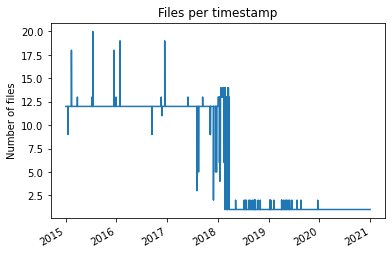

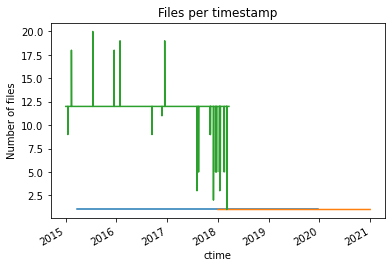

In [10]:
df_all_files.ctime.value_counts().sort_index().plot()
plt.title('Files per timestamp')
plt.ylabel('Number of files')
plt.show()

df_all_files.loc[df_all_files.extension == '.h5'].groupby('ctime').count().loc[:,'filename_noext'].plot()
df_all_files.loc[df_all_files.extension == '.vol.hdf5'].groupby('ctime').count().loc[:,'filename_noext'].plot()
df_all_files.loc[df_all_files.extension == '.H5'].groupby('ctime').count().loc[:,'filename_noext'].plot()
plt.title('Files per timestamp')
plt.ylabel('Number of files')
plt.show()

# Visualize: presence of each data type over time

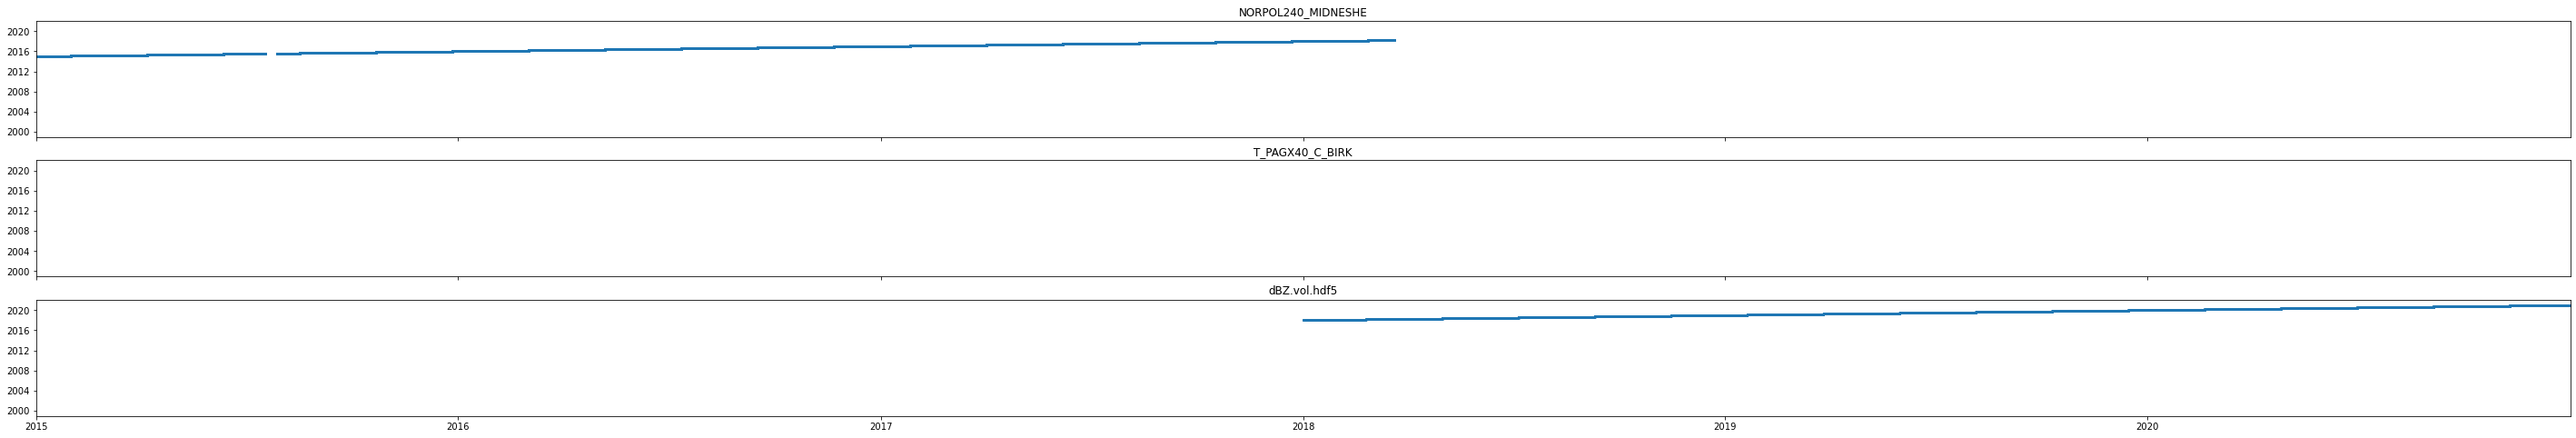

In [30]:
type_0 = df_all_files.loc[:,'filename'].str.contains(types[0])
type_1 = df_all_files.loc[:,'filename'].str.contains(types[1])
type_2 = df_all_files.loc[:,'filename'].str.contains(types[2])

f,axes = plt.subplots(3,1,figsize=(50,8),sharex=True,sharey=True)
axes[0].scatter(df_all_files.loc[type_0,'ctime'],df_all_files.loc[type_0,'ctime'],s = 0.5)
axes[0].set_title(types[0])
axes[1].scatter(df_all_files.loc[type_1,'ctime'],df_all_files.loc[type_1,'ctime'],s = 0.5)
axes[1].set_title(types[1])
axes[2].scatter(df_all_files.loc[type_2,'ctime'],df_all_files.loc[type_2,'ctime'],s = 0.5)
axes[2].set_title(types[2])
plt.xlim(df_all_files.ctime.min(),df_all_files.ctime.max())
plt.show()

# Decision: Drop all T_PAGX40_C_BIRK radar files


In [12]:
df_all_files = df_all_files.loc[~type_1]
len(df_all_files)

1625686

# Check number of non-12 layer images from old dataset

In [13]:
(df_all_files.loc[df_all_files.extension == '.H5'].groupby('ctime').count() != 12).sum()

url               23
extension         23
filename          23
filename_noext    23
dtype: int64

# Decision: Drop all non-12 layer images from old dataset

In [14]:
layers_per_timestamp = df_all_files.loc[df_all_files.extension == '.H5'].groupby('ctime').count().filename
non12timestamps = layers_per_timestamp[layers_per_timestamp != 12].index 
among_non12timestamps = df_all_files.loc[:,'ctime'].isin(non12timestamps)
df_all_files = df_all_files.loc[~among_non12timestamps]

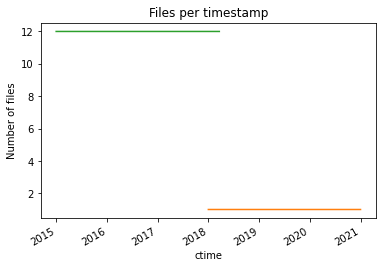

In [15]:
df_all_files.loc[df_all_files.extension == '.h5'].groupby('ctime').count().loc[:,'filename_noext'].plot()
df_all_files.loc[df_all_files.extension == '.vol.hdf5'].groupby('ctime').count().loc[:,'filename_noext'].plot()
df_all_files.loc[df_all_files.extension == '.H5'].groupby('ctime').count().loc[:,'filename_noext'].plot()
plt.title('Files per timestamp')
plt.ylabel('Number of files')
plt.show()

In [23]:
counts_per_filetype_time = df_all_files.groupby(['ctime','extension']).count().sort_index(0)
counts_per_filetype_time = counts_per_filetype_time.reset_index()

C:\Users\SVERRI~1\AppData\Local\Temp/ipykernel_20776/3437737658.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  counts_per_filetype_time = df_all_files.groupby(['ctime','extension']).count().sort_index(0)


In [29]:
counts_per_filetype_time.groupby(['ctime']).count().sort_values('url')

,extension,url,filename,filename_noext
ctime,,,,
2015-01-01 00:00:00,1,1,1,1
2019-09-27 20:55:00,1,1,1,1
2019-09-27 20:50:00,1,1,1,1
2019-09-27 20:45:00,1,1,1,1
2019-09-27 20:40:00,1,1,1,1
...,...,...,...,...
2018-02-06 01:55:00,2,2,2,2
2018-02-06 01:40:00,2,2,2,2
2018-02-06 01:25:00,2,2,2,2


# Extract all types of radar strategies used

## Extract elevation angles from each file

In [15]:
def extract_angle(name):
    if 'NORPOL240_MIDNESHE' in name:
        substring = name[len(types[0])+1:len(types[0])+5]
        substring_parts = substring.split('_')
        angle = float(substring_parts[0]) + float(substring_parts[1])/10
        return angle

In [16]:
df_all_files.loc[:,'angle'] = np.nan
df_all_files.loc[type_0,'angle'] = df_all_files.loc[type_0,'filename'].apply(extract_angle)

In [21]:
df_all_files.to_csv('file_metadata.csv')

## Check for single elevation files if the list of elevations per timestamps is always identical

In [17]:
angle_set_instances = df_all_files.loc[df_all_files.loc[:,'extension'] == '.H5'].groupby('ctime').apply(lambda x :  list(x['angle']))
angle_set_instances = angle_set_instances.apply(sorted)
strategies_string_list = angle_set_instances.apply(str)

In [18]:
strategies = strategies_string_list.value_counts()
strategies

[0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0, 15.0, 25.0, 40.0]    77081
[0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]    34008
dtype: int64

In [19]:
# strategies_string_list == strategies.index[0]

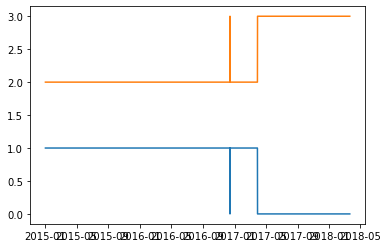

In [ ]:
plt.plot(1*(strategies_string_list == strategies.index[0]))
plt.plot(1*(strategies_string_list == strategies.index[1]) + 2)

In [ ]:
strategies_string_list.iloc[1:].loc[(strategies_string_list == strategies.index[1]*1).diff().fillna(False)]

ctime
2016-12-13 12:00:00    [0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0,...
2016-12-13 13:45:00    [0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0,...
2017-03-29 11:15:00    [0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0,...
dtype: object

# 1'000 samples from new radar files

In [ ]:
# df_all_files_new_filetype.shape

In [22]:
def recursive_unfolding(dict_object,prefix,ignore):
    all_key_value_pairs = []
    for key in dict_object:
        # print(key)
        child = dict_object[key]
        new_prefix = str(prefix) + '/' + str(key)
        if type(child) == dict:
            # print(new_prefix)
            all_key_value_pairs = all_key_value_pairs + recursive_unfolding(child,new_prefix,ignore)
        elif key not in ignore:
            # print(new_prefix)
            all_key_value_pairs.append((new_prefix,child))
            
    return all_key_value_pairs



df_all_files_new_filetype = df_all_files.loc[df_all_files.loc[:,'extension'] == '.vol.hdf5'].copy()
df_all_files_new_filetype = df_all_files_new_filetype.reset_index()
# file_ids = np.random.choice(np.arange(len(df_all_files_new_filetype)),1000)


dataframes = []
for index,row in df_all_files_new_filetype.iterrows():
    if index % 10000 == 0:
        print(index,datetime.datetime.now())
    url = row['url']
    name = row['filename_noext']
    
    file = wrl.io.read_generic_hdf5(url)
    unfolded = recursive_unfolding(file,'',['data'])
    df_unfolded = pd.DataFrame(unfolded)
    df_unfolded.loc[:,'url'] = url
    dataframes.append(df_unfolded)
    
combined_unfolded = pd.concat(dataframes)
combined_unfolded.to_csv('new_files_metadata.csv')

0 2021-10-19 14:13:48.034165
10000 2021-10-19 14:18:18.872444
20000 2021-10-19 14:21:57.139200
30000 2021-10-19 14:25:29.021871
40000 2021-10-19 14:28:59.117480
50000 2021-10-19 14:32:31.015554
60000 2021-10-19 14:36:37.331664
70000 2021-10-19 14:41:03.253588
80000 2021-10-19 14:45:17.926723
90000 2021-10-19 14:49:31.755032
100000 2021-10-19 14:53:23.987418
110000 2021-10-19 14:57:17.419700
120000 2021-10-19 15:01:10.843368
130000 2021-10-19 15:04:54.698851
140000 2021-10-19 15:08:43.146861
150000 2021-10-19 15:12:31.182979
160000 2021-10-19 15:16:50.300398
170000 2021-10-19 15:20:56.367579
180000 2021-10-19 15:24:51.644627
190000 2021-10-19 15:28:50.346319
200000 2021-10-19 15:33:10.139625
210000 2021-10-19 15:37:42.780001
220000 2021-10-19 15:41:33.446523
230000 2021-10-19 15:45:24.186293
240000 2021-10-19 15:49:13.624442
250000 2021-10-19 15:53:04.978647
260000 2021-10-19 15:56:57.876886
270000 2021-10-19 16:00:45.458324
280000 2021-10-19 16:04:34.437334
290000 2021-10-19 16:08:19.4

In [ ]:
df_all_files_new_filetype

,url,extension,filename,filename_noext,ctime,angle
1243021,C:/Users/sverrirhd/vedurgogn//radar\201801\201...,.vol.hdf5,2018010100100000dBZ.vol.hdf5,2018010100100000dBZ,2018-01-01 00:10:00,NaN
1243027,C:/Users/sverrirhd/vedurgogn//radar\201801\201...,.vol.hdf5,2018010100250000dBZ.vol.hdf5,2018010100250000dBZ,2018-01-01 00:25:00,NaN
1243037,C:/Users/sverrirhd/vedurgogn//radar\201801\201...,.vol.hdf5,2018010100400000dBZ.vol.hdf5,2018010100400000dBZ,2018-01-01 00:40:00,NaN
1243059,C:/Users/sverrirhd/vedurgogn//radar\201801\201...,.vol.hdf5,2018010100550000dBZ.vol.hdf5,2018010100550000dBZ,2018-01-01 00:55:00,NaN
1243062,C:/Users/sverrirhd/vedurgogn//radar\201801\201...,.vol.hdf5,2018010101100000dBZ.vol.hdf5,2018010101100000dBZ,2018-01-01 01:10:00,NaN
...,...,...,...,...,...,...
1626176,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123350000dBZ.vol.hdf5,2020123123350000dBZ,2020-12-31 23:35:00,NaN
1626177,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123400000dBZ.vol.hdf5,2020123123400000dBZ,2020-12-31 23:40:00,NaN
1626178,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123450000dBZ.vol.hdf5,2020123123450000dBZ,2020-12-31 23:45:00,NaN
1626179,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123500000dBZ.vol.hdf5,2020123123500000dBZ,2020-12-31 23:50:00,NaN


In [ ]:
len(df_all_files_new_filetype)

292395

In [ ]:
combined_unfolded.loc[:,0].value_counts()

/dataset1/data1/data/attrs/CLASS        1000
/dataset3/where/attrs/rstart            1000
/dataset3/where/attrs/nrays             1000
/dataset3/where/attrs/nbins             1000
/dataset3/where/attrs/elangle           1000
                                        ... 
/dataset11/data1/what/attrs/quantity      24
/dataset11/data1/what/attrs/offset        24
/dataset11/data1/what/attrs/nodata        24
/dataset11/data1/what/attrs/gain          24
/dataset9/where/attrs/rstart              24
Name: 0, Length: 244, dtype: int64

In [ ]:
is_elangle = combined_unfolded.loc[:,0].str.contains('elangle')

In [ ]:
new_file_strategies_list = combined_unfolded.loc[is_elangle].groupby('url').apply(lambda x : sorted(list(x[1])))

In [ ]:
strategies

[0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0, 15.0, 25.0, 40.0]    77081
[0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]    34008
dtype: int64

In [ ]:
strategies_counts = new_file_strategies_list.astype(str).value_counts()
strategies_counts

[0.5, 1.297, 2.396, 5.0, 7.0, 10.0, 15.0, 20.0]                                                   968
[0.5, 0.896, 1.297, 2.396, 3.5, 4.5, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]                             24
[1.297, 2.396, 5.0, 7.0, 10.0, 15.0, 20.0]                                                          2
[0.5, 0.5, 1.297, 1.297, 2.396, 2.396, 5.0, 5.0, 7.0, 7.0, 10.0, 10.0, 15.0, 15.0, 20.0, 20.0]      2
[1.297, 5.0, 7.0]                                                                                   1
[10.0, 15.0, 20.0]                                                                                  1
dtype: int64

# Parse all new files into metadata dataframes, batched into smaller datasets and saved

In [ ]:
strategies_counts.index[0]
new_file_strategies_list

url
C:/Users/sverrirhd/vedurgogn//radar\201801\2018010610400000dBZ.vol.hdf5    [0.5, 0.896, 1.297, 2.396, 3.5, 4.5, 6.0, 8.0,...
C:/Users/sverrirhd/vedurgogn//radar\201801\2018011803100000dBZ.vol.hdf5    [0.5, 0.896, 1.297, 2.396, 3.5, 4.5, 6.0, 8.0,...
C:/Users/sverrirhd/vedurgogn//radar\201801\2018012002550000dBZ.vol.hdf5    [0.5, 0.896, 1.297, 2.396, 3.5, 4.5, 6.0, 8.0,...
C:/Users/sverrirhd/vedurgogn//radar\201801\2018012415550000dBZ.vol.hdf5    [0.5, 0.896, 1.297, 2.396, 3.5, 4.5, 6.0, 8.0,...
C:/Users/sverrirhd/vedurgogn//radar\201801\2018012705250000dBZ.vol.hdf5    [0.5, 0.896, 1.297, 2.396, 3.5, 4.5, 6.0, 8.0,...
                                                                                                 ...                        
C:/Users/sverrirhd/vedurgogn//radar\202012\2020122704000000dBZ.vol.hdf5      [0.5, 1.297, 2.396, 5.0, 7.0, 10.0, 15.0, 20.0]
C:/Users/sverrirhd/vedurgogn//radar\202012\2020122716050000dBZ.vol.hdf5      [0.5, 1.297, 2.396, 5.0, 7.0, 10.0, 15.0, 20

<AxesSubplot:>

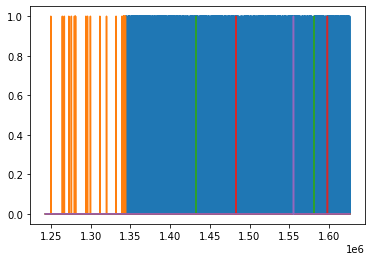

In [ ]:
main_strat_files_samples = new_file_strategies_list.loc[new_file_strategies_list.astype(str) == strategies_counts.index[0]]
(df_all_files_new_filetype.url.isin(main_strat_files_samples.index)*1).plot()
main_strat_files_samples = new_file_strategies_list.loc[new_file_strategies_list.astype(str) == strategies_counts.index[1]]
(df_all_files_new_filetype.url.isin(main_strat_files_samples.index)*1).plot()
main_strat_files_samples = new_file_strategies_list.loc[new_file_strategies_list.astype(str) == strategies_counts.index[2]]
(df_all_files_new_filetype.url.isin(main_strat_files_samples.index)*1).plot()
main_strat_files_samples = new_file_strategies_list.loc[new_file_strategies_list.astype(str) == strategies_counts.index[3]]
(df_all_files_new_filetype.url.isin(main_strat_files_samples.index)*1).plot()
main_strat_files_samples = new_file_strategies_list.loc[new_file_strategies_list.astype(str) == strategies_counts.index[4]]
(df_all_files_new_filetype.url.isin(main_strat_files_samples.index)*1).plot()

,url,extension,filename,filename_noext,ctime,angle
0,C:/Users/sverrirhd/vedurgogn//radar\201501\NOR...,.H5,NORPOL240_MIDNESHE_00_5_20150101_0000_O.H5,NORPOL240_MIDNESHE_00_5_20150101_0000_O,2015-01-01 00:00:00,0.5
1,C:/Users/sverrirhd/vedurgogn//radar\201501\NOR...,.H5,NORPOL240_MIDNESHE_03_5_20150101_0000_O.H5,NORPOL240_MIDNESHE_03_5_20150101_0000_O,2015-01-01 00:00:00,3.5
2,C:/Users/sverrirhd/vedurgogn//radar\201501\NOR...,.H5,NORPOL240_MIDNESHE_06_0_20150101_0000_O.H5,NORPOL240_MIDNESHE_06_0_20150101_0000_O,2015-01-01 00:00:00,6.0
3,C:/Users/sverrirhd/vedurgogn//radar\201501\NOR...,.H5,NORPOL240_MIDNESHE_08_0_20150101_0000_O.H5,NORPOL240_MIDNESHE_08_0_20150101_0000_O,2015-01-01 00:00:00,8.0
4,C:/Users/sverrirhd/vedurgogn//radar\201501\NOR...,.H5,NORPOL240_MIDNESHE_02_4_20150101_0000_O.H5,NORPOL240_MIDNESHE_02_4_20150101_0000_O,2015-01-01 00:00:00,2.4
...,...,...,...,...,...,...
1626176,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123350000dBZ.vol.hdf5,2020123123350000dBZ,2020-12-31 23:35:00,NaN
1626177,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123400000dBZ.vol.hdf5,2020123123400000dBZ,2020-12-31 23:40:00,NaN
1626178,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123450000dBZ.vol.hdf5,2020123123450000dBZ,2020-12-31 23:45:00,NaN
1626179,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123500000dBZ.vol.hdf5,2020123123500000dBZ,2020-12-31 23:50:00,NaN


In [ ]:
batch_folder_url = './metadata_batches/'


In [ ]:
list_of_values = combined_unfolded.groupby('last_key').apply(lambda x : list(x.loc[:,1]))
n_unique = list_of_values.apply(np.unique).apply(len)

In [ ]:
# n_unique

In [ ]:
list_of_values = combined_unfolded.groupby('last_key').apply(lambda x : list(x.loc[:,1]))
n_unique = list_of_values.apply(np.unique).apply(len)

In [ ]:
# n_unique

In [ ]:
n_unique.sort_values(ascending=False)

last_key
starttime        2139
endtime          1367
stoptime          807
date              741
startdate         741
stopdate          582
time              353
startepochs       172
stopepochs        172
enddate           159
angle              14
elangle            14
radar_msg           7
offset              2
object              2
lat                 2
system              2
quantity            2
nodata              2
software            2
lowprf              2
lon                 2
highprf             2
height              2
gain                2
beamwidth           2
version             2
wavelength          2
sets                1
undetect            1
xscale              1
xsize               1
source              1
CLASS               1
place               1
rstart              1
rscale              1
rpm                 1
radar_fail          1
pulsewidth          1
product             1
IMAGE_VERSION       1
nrays               1
nbins               1
doppler             1
b

In [ ]:
combined_unfolded

,0,1,url,last_key
0,/how/attrs/WMO,2334,C:/Users/sverrirhd/vedurgogn//radar\201605\NOR...,WMO
1,/how/attrs/azmethod,b'RANDOM',C:/Users/sverrirhd/vedurgogn//radar\201605\NOR...,azmethod
2,/how/attrs/beamwidth,0.9,C:/Users/sverrirhd/vedurgogn//radar\201605\NOR...,beamwidth
3,/how/attrs/binmethod,b'AVERAGE',C:/Users/sverrirhd/vedurgogn//radar\201605\NOR...,binmethod
4,/how/attrs/doppler,0,C:/Users/sverrirhd/vedurgogn//radar\201605\NOR...,doppler
...,...,...,...,...
32,/where/attrs/lat,64.025002,C:/Users/sverrirhd/vedurgogn//radar\201707\NOR...,lat
33,/where/attrs/lon,-22.636,C:/Users/sverrirhd/vedurgogn//radar\201707\NOR...,lon
34,/where/attrs/xscale,2000.0,C:/Users/sverrirhd/vedurgogn//radar\201707\NOR...,xscale
35,/where/attrs/xsize,120,C:/Users/sverrirhd/vedurgogn//radar\201707\NOR...,xsize


In [ ]:
combined_unfolded.loc[:,'last_key'].value_counts()

offset           2241
undetect         2241
starttime        2241
startdate        2241
quantity         2241
product          2241
nodata           2241
gain             2241
enddate          1413
IMAGE_VERSION    1413
CLASS            1413
azangles         1413
endtime          1413
a1gate           1413
elangle          1413
nbins            1413
nrays            1413
rscale           1413
rstart           1413
object           1000
version          1000
height           1000
lat              1000
time             1000
date             1000
wavelength       1000
system           1000
software         1000
lowprf           1000
highprf          1000
beamwidth        1000
lon              1000
xsize             828
ysize             828
WMO               828
xscale            828
angle             828
sets              828
azmethod          828
stoptime          828
stopdate          828
rpm               828
radar_msg         828
radar_fail        828
pulsewidth        828
place     

In [ ]:
df_unfolded.loc[df_unfolded.loc[:,'last_key'] == 'pulse width']

KeyError: 'last_key'

In [ ]:
unfolded = recursive_unfolding(dict_tmp,tuple)
df_unfolded = pd.DataFrame(unfolded)
# df_unfolded.loc[:,'last_key'] = df_unfolded.loc[:,0].apply(lambda x : x[-1])

In [ ]:
df_unfolded.loc[df_unfolded.loc[:,'last_key'] == 'pulse width']

,0,1,last_key


In [ ]:
# df_unfolded

In [ ]:
files = []
for url in df_all_files.loc[:,'url']:
    file = wrl.io.read_generic_hdf5(url)
    # files.append(file)
    extract_strategy(file)

[[None]] [[None]]


TypeError: unsupported operand type(s) for -: 'list' and 'int'

('attrs',) WMO
('attrs',) azmethod
('attrs',) beamwidth
('attrs',) binmethod
('attrs',) doppler
('attrs',) highprf
('attrs',) lowprf
('attrs',) place
('attrs',) pulsewidth
('attrs',) radar_fail
('attrs',) radar_msg
('attrs',) rpm
('attrs',) software
('attrs',) system
('attrs',) wavelength
('scan1/data',) data
('attrs',) gain
('attrs',) nodata
('attrs',) offset
('attrs',) product
('attrs',) quantity
('attrs',) startdate
('attrs',) starttime
('attrs',) stopdate
('attrs',) stoptime
('attrs',) undetect
('attrs',) date
('attrs',) object
('attrs',) sets
('attrs',) time
('attrs',) version
('attrs',) angle
('attrs',) height
('attrs',) lat
('attrs',) lon
('attrs',) xscale
('attrs',) xsize
('attrs',) ysize


,0,1
0,"(attrs, WMO)",2334
1,"(attrs, azmethod)",b'RANDOM'
2,"(attrs, beamwidth)",0.9
3,"(attrs, binmethod)",b'AVERAGE'
4,"(attrs, doppler)",0
5,"(attrs, highprf)",250
6,"(attrs, lowprf)",250
7,"(attrs, place)",b'Keflavik'
8,"(attrs, pulsewidth)",2.0
9,"(attrs, radar_fail)",0


<AxesSubplot:xlabel='ctime'>

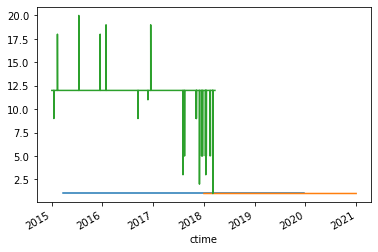

# Type 1 radar strategy

<AxesSubplot:title={'center':'Radar Scan Strategy - (64.025, -22.636, 47)'}, xlabel='Range (km)', ylabel='Altitude (km)'>

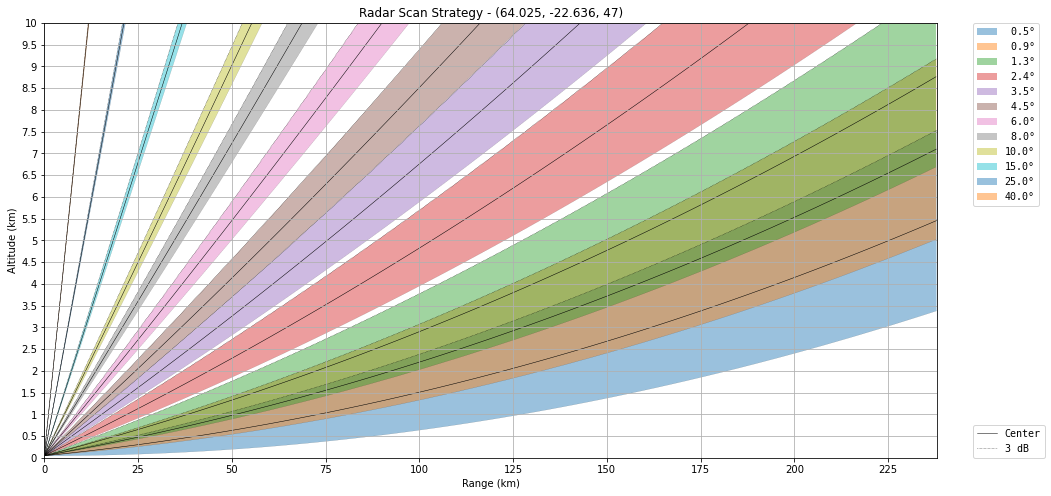

In [ ]:
dict_tmp =  wrl.io.read_generic_hdf5('C:/Users/sverrirhd/vedurgogn//radar\\201503\\T_PAGX40_C_BIRK_20150324220000.h5')
radar_strat_tmp = extract_strategy(dict_tmp)

wrl.vis.plot_scan_strategy(ranges = radar_strat_tmp['ranges'],
                                elevs = radar_strat_tmp['elevs'],
                                sitecoords = radar_strat_tmp['sitecoords'],
                                beamwidth = radar_strat_tmp['beamwidth'],
                                units='km',
                                maxrange = radar_strat_tmp['maxrange'])

# type 2 radar strategy

In [ ]:
'vert' in str(dict_tmp),'hor' in str(dict_tmp)

(False, False)

<AxesSubplot:title={'center':'Radar Scan Strategy - (64.025, -22.636, 47)'}, xlabel='Range (km)', ylabel='Altitude (km)'>

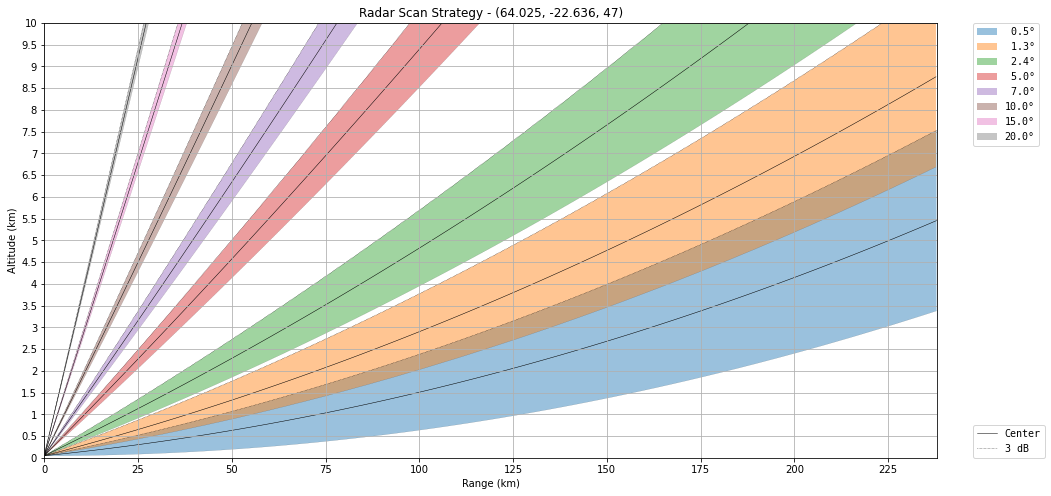

In [ ]:
dict_tmp =  wrl.io.read_generic_hdf5('C:/Users/sverrirhd/vedurgogn//radar\\202012\\2020123123550000dBZ.vol.hdf5')
radar_strat_tmp = extract_strategy(dict_tmp)

wrl.vis.plot_scan_strategy(ranges = radar_strat_tmp['ranges'],
                           elevs = radar_strat_tmp['elevs'],
                           sitecoords = radar_strat_tmp['sitecoords'],
                           beamwidth = radar_strat_tmp['beamwidth'],
                           units='km',
                           maxrange = radar_strat_tmp['maxrange'])


    # ranges,
    # elevs,
    # sitecoords,
    # beamwidth=1.0,
    # vert_res=500.0,
    # maxalt=10000.0,
    # range_res=None,
    # maxrange=None,
    # units="m",
    # terrain=None,
    # az=0.0,
    # cg=False,
    # ax=111,
    # cmap="tab10",

<AxesSubplot:title={'center':'Radar Scan Strategy - (64.025, -22.636, 47)'}, xlabel='Range (km)', ylabel='Altitude (km)'>

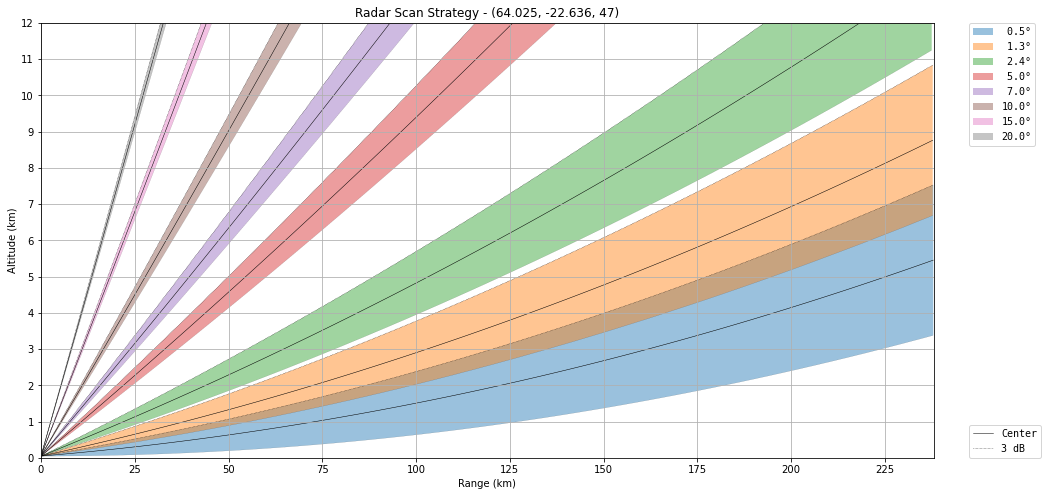

In [ ]:
dict_tmp =  wrl.io.read_generic_hdf5('C:/Users/sverrirhd/vedurgogn//radar\\202012\\2020123123550000dBZ.vol.hdf5')
radar_strat_tmp = extract_strategy(dict_tmp)

wrl.vis.plot_scan_strategy(ranges = radar_strat_tmp['ranges'],
                           elevs = radar_strat_tmp['elevs'],
                           sitecoords = radar_strat_tmp['sitecoords'],
                           beamwidth = radar_strat_tmp['beamwidth'],
                           units='km',
                           maxrange = radar_strat_tmp['maxrange'],
                           vert_res = 1000,
                           maxalt = 12000)



# Type 0 radar strategy

In [ ]:
grouped_radar_files = df_all_files.iloc[:1000].groupby('ctime').apply(lambda x : list(df_all_files.loc[x.index,'url']))

In [ ]:
grouped_radar_files
radar_batch = grouped_radar_files.iloc[0]
batch_dict_files = []
for i in radar_batch:
    batch_dict_tmp =  wrl.io.read_generic_hdf5(i)
    batch_dict_files.append(batch_dict_tmp)

In [ ]:
# Common variables
single_file = batch_dict_files[0]
sitecoords = (single_file['where']['lat'],single_file['where']['lon'])

elangles = []
for file in batch_dict_files:
    elangles.append(file['where']['angle'])
    print(file['where'])

KeyError: 'lat'

In [ ]:
[i.keys() for i in batch_dict_files]

[dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where']),
 dict_keys(['how', 'scan1/data', 'scan1/what', 'what', 'where'])]

In [ ]:
batch_dict_files[0]['how']

{'attrs': {'WMO': 2334,
  'azmethod': b'RANDOM',
  'beamwidth': 0.9,
  'binmethod': b'AVERAGE',
  'doppler': 0,
  'highprf': 250,
  'lowprf': 250,
  'place': b'Keflavik',
  'pulsewidth': 2.0,
  'radar_fail': 0,
  'radar_msg': b'b14 3b5 001 004 8ff:',
  'rpm': 2.0,
  'software': b'PARTEC2',
  'system': b'ERIC',
  'wavelength': 5.35}}

In [ ]:
batch_dict_files[0]['where']

{'attrs': {'angle': 0.5,
  'height': 45.0,
  'lat': 64.025,
  'lon': -22.636,
  'xscale': 2000.0,
  'xsize': 120,
  'ysize': 420}}

In [ ]:
dict_tmp['how']

{'attrs': {'beamwidth': 1.0,
  'highprf': 1200,
  'lowprf': 0,
  'software': b'RAINBOW',
  'startepochs': 1609459144,
  'stopepochs': 1609458921,
  'system': b'KEF',
  'wavelength': 5.0}}

In [ ]:
dict_tmp =  wrl.io.read_generic_hdf5('C:/Users/sverrirhd/vedurgogn//radar\\201501\\NORPOL240_MIDNESHE_00_5_20150101_0000_O.H5')
radar_strat_tmp = extract_strategy(dict_tmp)

# wrl.vis.plot_scan_strategy(ranges = radar_strat_tmp['ranges'],
#                                 elevs = radar_strat_tmp['elevs'],
#                                 sitecoords = radar_strat_tmp['sitecoords'],
#                                 beamwidth = radar_strat_tmp['beamwidth'],
#                                 units='km',
#                                 maxrange = radar_strat_tmp['maxrange'])

KeyError: 'dataset1/where'

,url,extension,filename,filename_noext,ctime
0,C:/Users/sverrirhd/vedurgogn//radar\201501\NOR...,.H5,NORPOL240_MIDNESHE_00_5_20150101_0000_O.H5,NORPOL240_MIDNESHE_00_5_20150101_0000_O,2015-01-01 00:00:00
1,C:/Users/sverrirhd/vedurgogn//radar\201501\NOR...,.H5,NORPOL240_MIDNESHE_06_0_20150101_0000_O.H5,NORPOL240_MIDNESHE_06_0_20150101_0000_O,2015-01-01 00:00:00
2,C:/Users/sverrirhd/vedurgogn//radar\201501\NOR...,.H5,NORPOL240_MIDNESHE_03_5_20150101_0000_O.H5,NORPOL240_MIDNESHE_03_5_20150101_0000_O,2015-01-01 00:00:00
3,C:/Users/sverrirhd/vedurgogn//radar\201501\NOR...,.H5,NORPOL240_MIDNESHE_08_0_20150101_0000_O.H5,NORPOL240_MIDNESHE_08_0_20150101_0000_O,2015-01-01 00:00:00
4,C:/Users/sverrirhd/vedurgogn//radar\201501\NOR...,.H5,NORPOL240_MIDNESHE_02_4_20150101_0000_O.H5,NORPOL240_MIDNESHE_02_4_20150101_0000_O,2015-01-01 00:00:00
...,...,...,...,...,...
1625949,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123350000dBZ.vol.hdf5,2020123123350000dBZ,2020-12-31 23:35:00
1625950,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123400000dBZ.vol.hdf5,2020123123400000dBZ,2020-12-31 23:40:00
1625951,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123450000dBZ.vol.hdf5,2020123123450000dBZ,2020-12-31 23:45:00
1625952,C:/Users/sverrirhd/vedurgogn//radar\202012\202...,.vol.hdf5,2020123123500000dBZ.vol.hdf5,2020123123500000dBZ,2020-12-31 23:50:00
